# Setup

In [11]:
import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
import seaborn as sns
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2 as cv
import math
#import tensorflow.keras.metrics
#from keras import ops

In [ ]:
## Execute this when running the notebook on google colab
from google.colab import drive
drive.mount('/content/drive')
# Then change this to your own folder path containing the notebook
folder_path = "/content/drive/MyDrive/TREC_Codage"

Mounted at /content/drive


In [12]:
# When running in local
folder_path = ""

# Dataset loading

## Separation and resizing of pictures

In [ ]:
# To load dataset in pickle format
import pickle
file = f'{folder_path}/data_resultsheets/data.pkl'
with open(file, 'rb') as f:
      pict, label = pickle.load(f)
print(pict.shape)
print(label.shape)

(1719, 74, 74)
(1719,)


In [3]:
# Importation and merge of dataset from all the resultsheets
file_name = [f"0{x}" for x in range(1, 10)]
full_da = np.loadtxt(f'{folder_path}data_resultsheets/{file_name[0]}.csv', dtype = "int32", delimiter=',')
for file in file_name[1:]:
    da = np.loadtxt(f'{folder_path}data_resultsheets/{file}.csv', dtype = "int32", delimiter=',')
    full_da = np.append(full_da, da, axis = 0)
file_name_b2 = [f"IMG_000{x}" for x in range(1, 10)]
for file in file_name_b2:
    da = np.loadtxt(f'{folder_path}data_resultsheets/{file}.csv', dtype = "int32", delimiter=',')
    full_da = np.append(full_da, da, axis = 0)
print(full_da.shape)
print(full_da)


(3412, 6233)
[[255 255 255 ... 255 255   1]
 [255 255 255 ... 255 255   1]
 [255 255 255 ... 255 255   1]
 ...
 [255 255 255 ... 255 255   9]
 [255 255 255 ... 255 255   9]
 [255 255 255 ... 255 255   9]]


In [13]:
full_da = np.loadtxt(f'{folder_path}data_resultsheets/Train/b3_0001.csv', dtype = "int32", delimiter=',')
print(full_da.shape)
print(full_da)


(191, 6233)
[[255 255 255 ... 255 255   1]
 [255 255 255 ... 255 255   1]
 [255 255 255 ... 255 255   1]
 ...
 [255 255 255 ... 255 255   1]
 [255 255 255 ... 255 255   1]
 [255 255 255 ... 255 255   1]]


(191,)


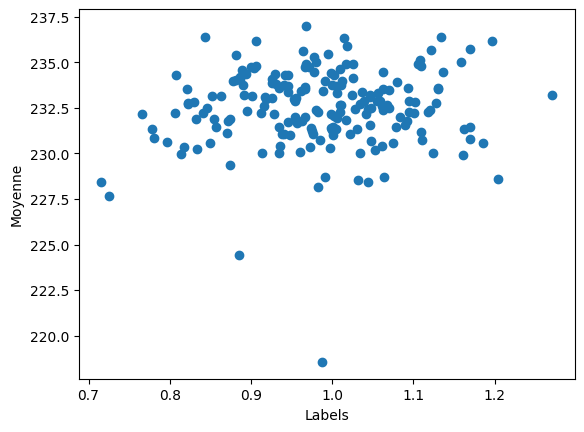

In [14]:
# Plotting mean pixel intensity in function of label.
mean_pix = full_da[:, :-1].mean(axis=1)
print(mean_pix.shape)
labels = full_da[:, -1]
jitter = np.random.normal(0, 0.1, size=len(labels))
plt.plot(labels + jitter, mean_pix, 'o')
plt.xlabel('Labels')
plt.ylabel('Moyenne')
plt.show()
# We can see that for some labels there are two groups of points
# Suggest differences in the two sheets used for annotation
# Maybe due to variation in scanning or writing intensity

In [15]:
# Separation of images and labels
pict, label = np.split(full_da, [6232], axis = 1)
#pict = full_da_split[0]
#label = full_da_split[1]
print(pict.shape)
print(label.shape)
# Reshape pict data into matrices corresponding to image size used in extraction
pict = pict.reshape((len(pict), 76, 82))
print(pict.shape)

(191, 6232)
(191, 1)
(191, 76, 82)


In [16]:
# Redimension pictures
new_size = (56, 56)
pict = pict.astype(np.float32)
pict = pict.reshape(-1, pict.shape[1], pict.shape[2], 1)
pict_redim = np.empty((len(pict), 56, 56))
# Boucle sur chaque image de l'array
for i in range(len(pict)):
    img_resized = cv.resize(pict[i], new_size, interpolation=cv.INTER_AREA)
    pict_redim[i] = img_resized
print(pict_redim.shape)

(191, 56, 56)


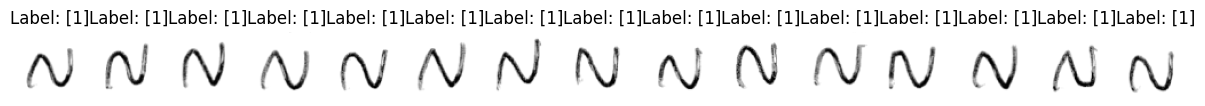

In [17]:
# Define a function to visualize samples from the dataset
def visualize_random_samples(X, y, num_samples=5):
    # Obtain a subset of random indices
    sample_indices = np.random.choice(len(X), num_samples, replace=False)

    # Create a grid plot for the samples
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 3))
    for i, idx in enumerate(sample_indices):
        # Reshape and display each sample as an image
        axes[i].imshow(X[idx], cmap='gray')
        # Set the title for each subplot as the corresponding label
        axes[i].set_title(f"Label: {y[idx]}")
        # Hide axis ticks for a cleaner look
        axes[i].axis('off')
    # Adjust layout for better spacing between subplots
    plt.tight_layout()
    # Display the plot
    plt.show()

# Call the function to visualize 10 random samples from the dataset
visualize_random_samples(pict_redim, label, num_samples=15)



In [9]:
# Function to visualize all symbols corresponding to certain labels
def visualize_symbols(images, labels, imgperrow = 12):
    for l in np.unique(labels):
        label_mask = (labels == l)
        img_indices = np.where(label_mask)[0]

        n_rows = math.ceil(len(images[img_indices]) / imgperrow)
        fig, axs = plt.subplots(n_rows, imgperrow, figsize=(imgperrow, n_rows))

        for i, pixels in enumerate(images[img_indices]):
            row = i // imgperrow
            col = i % imgperrow
            ax = axs[row, col]
            ax.imshow(pixels, cmap = 'gray')
            ax.text(0.5, 1.02, str(img_indices[i]), transform=ax.transAxes, ha='center', va='bottom', fontsize=10)
            ax.axis('off')
        fig.suptitle(f'Label {l}', fontsize=16)
        fig.subplots_adjust(top=0.75)
        plt.show()

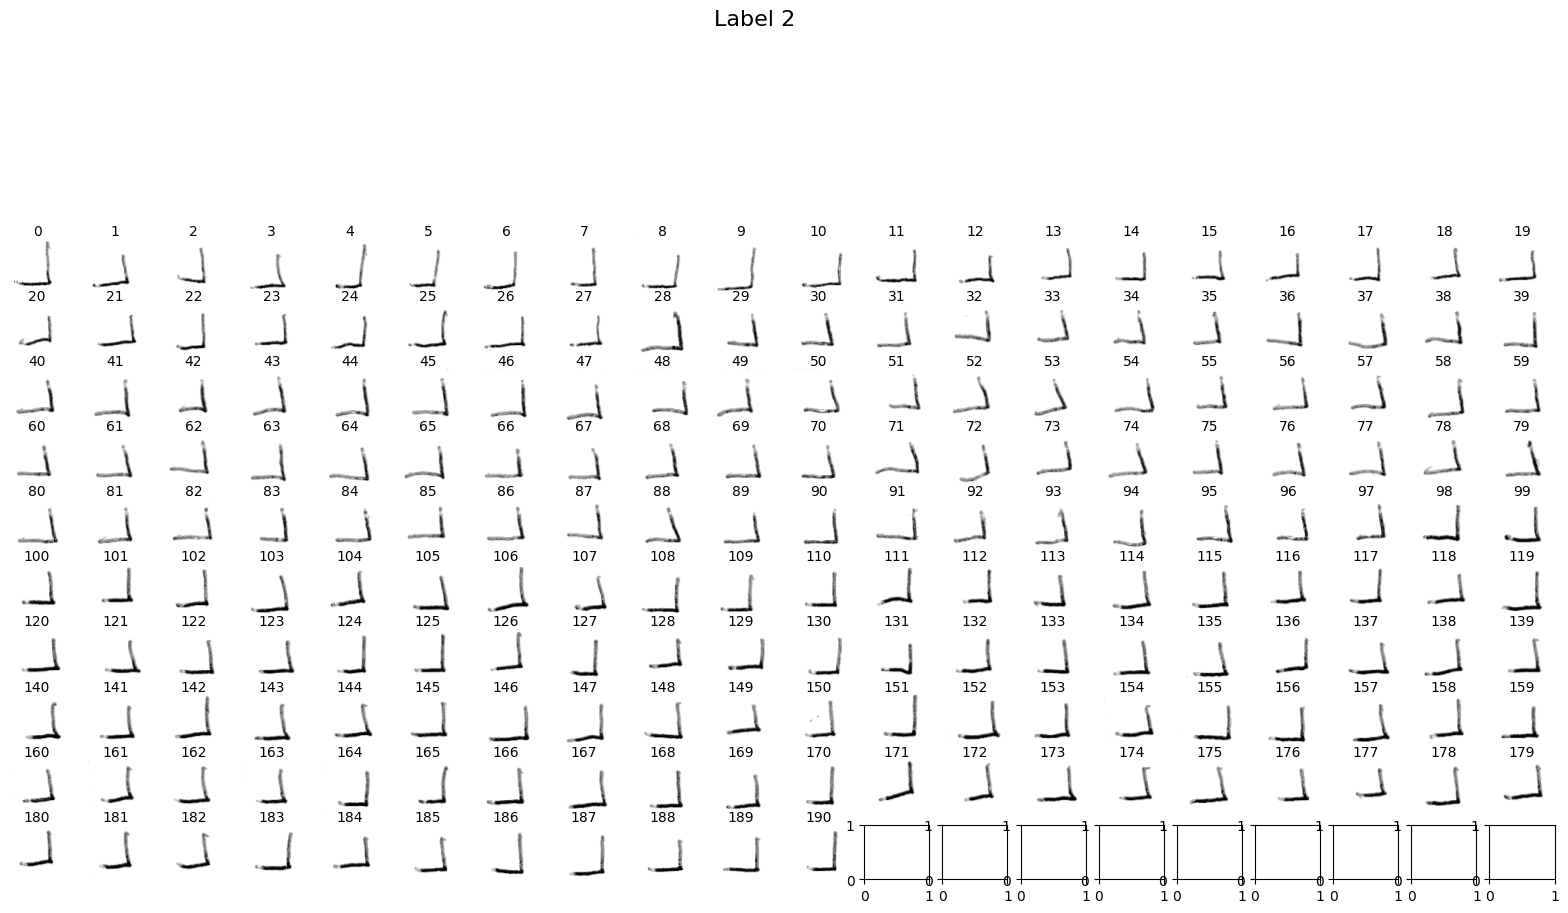

In [10]:
visualize_symbols(images=pict_redim, labels=label, imgperrow = 20)

## Train-test split

Training DataArray :
(3070, 56, 56)
(3070, 1)
Test DataArray :
(342, 56, 56)
(342, 1)


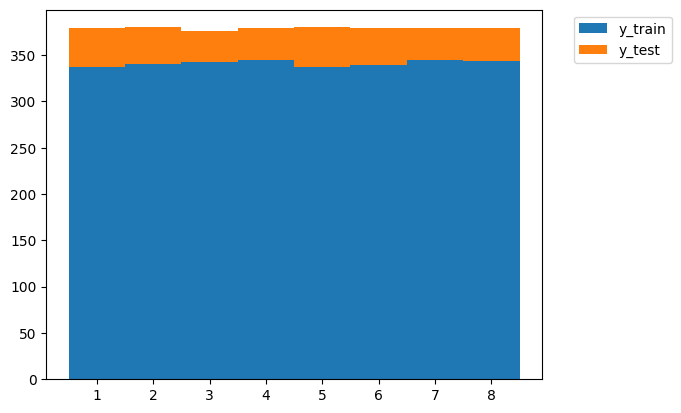

In [9]:
# Split the DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pict_redim, label, test_size=0.1, random_state=42)

# Display the first five rows of the training DataFrame
print("Training DataArray :")
print(X_train.shape)
print(y_train.shape)

# Display the first five rows of the test DataFrame
print("Test DataArray :")
print(X_test.shape)
print(y_test.shape)
plt.hist([y_train.flatten(), y_test.flatten()], bins=np.arange(0.5, 9.5, 1), stacked=True, label=['y_train', 'y_test'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [49]:
# Get the shape of the first training sample
print(X_train[0].shape)


(56, 56)


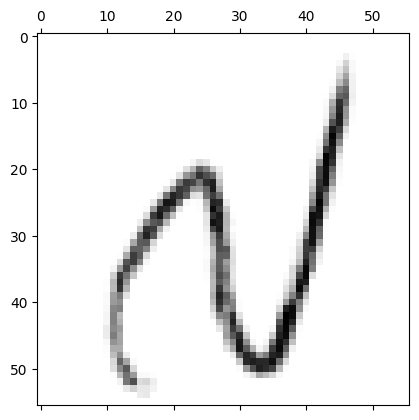

In [50]:
# Visualize the third training sample as an image
plt.matshow(X_train[2], cmap = "gray")
plt.show()  # Display the plot

## Normalisation and creation of picture vectors

In [10]:
# Normalize the pixel values of the images to be between 0 and 1
X_train = X_train / 255
X_test = X_test / 255


# Training of the model

In [11]:
# Define the model
model = keras.Sequential([
    keras.Input(shape=(56,56)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(9, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train-1, epochs=90, batch_size=64)



Epoch 1/90
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1418 - loss: 2.8147
Epoch 2/90
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2853 - loss: 1.9857
Epoch 3/90
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4827 - loss: 1.7125
Epoch 4/90
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5877 - loss: 1.4463
Epoch 5/90
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6677 - loss: 1.2307
Epoch 6/90
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7068 - loss: 1.0695
Epoch 7/90
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7443 - loss: 0.9449
Epoch 8/90
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7269 - loss: 0.9267
Epoch 9/90
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7453 - loss: 0.8565
Epoch 10/90
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7516 - loss: 0.8148
Epoch 11/90
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7687 - loss: 0.7823
Epoch 12/90
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8171 - lo

# Evaluation of model

In [12]:
# Evaluate the model on the test set
# Subtracting 1 from y_test to align labels if they originally start from 1
test_loss, test_accuracy = model.evaluate(X_test, y_test - 1)
# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9426 - loss: 0.2083  
Test Loss: 0.25501370429992676
Test Accuracy: 0.9356725215911865


In [13]:
# Generate predictions for the test set
y_predicted = model.predict(X_test)
# Use np.argmax to find the index of the maximum value in the first set of predictions,
# which corresponds to the model's predicted class label for the first image
# Pour détecter les erreur: ajouter une conditions : si
predicted_label = np.argmax(y_predicted[0])
# Convert the model's predictions from probability distributions to class labels
# by finding the index of the max probability for each prediction and adding 1
y_predicted_labels = [np.argmax(i) + 1 if max(i) > 0.7 else 0 for i in y_predicted]

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [14]:
print(y_predicted_labels)

[2, 3, 1, 4, 6, 7, 8, 2, 3, 8, 5, 6, 2, 6, 0, 7, 4, 5, 6, 4, 9, 4, 7, 6, 1, 5, 3, 8, 5, 9, 9, 6, 9, 1, 7, 1, 3, 7, 9, 2, 5, 3, 2, 3, 3, 6, 8, 9, 5, 3, 4, 7, 9, 4, 3, 4, 4, 3, 0, 9, 8, 6, 5, 5, 1, 8, 9, 3, 8, 9, 9, 1, 1, 2, 7, 8, 4, 8, 7, 4, 7, 7, 3, 6, 1, 7, 1, 6, 7, 7, 5, 2, 7, 6, 9, 7, 8, 5, 8, 2, 9, 1, 5, 1, 6, 1, 8, 3, 1, 5, 4, 0, 4, 2, 2, 6, 0, 1, 1, 7, 3, 3, 7, 7, 4, 5, 5, 8, 5, 7, 7, 8, 1, 4, 6, 5, 5, 5, 4, 1, 3, 4, 7, 9, 0, 4, 5, 2, 2, 1, 4, 6, 7, 5, 4, 6, 9, 0, 5, 9, 6, 2, 7, 5, 2, 5, 5, 2, 5, 5, 8, 0, 6, 2, 7, 1, 1, 1, 1, 6, 4, 9, 3, 8, 3, 1, 9, 4, 2, 0, 6, 4, 8, 5, 8, 6, 4, 3, 6, 0, 6, 8, 1, 3, 3, 1, 7, 6, 5, 8, 3, 8, 5, 6, 9, 2, 4, 0, 3, 2, 3, 5, 5, 3, 1, 9, 5, 4, 3, 5, 2, 5, 2, 1, 9, 5, 9, 8, 3, 0, 9, 1, 2, 5, 2, 6, 8, 4, 7, 6, 6, 7, 7, 2, 0, 8, 2, 9, 6, 3, 7, 6, 5, 1, 8, 0, 7, 9, 2, 7, 0, 0, 5, 8, 9, 4, 9, 2, 0, 9, 8, 5, 5, 2, 3, 3, 5, 1, 7, 6, 6, 6, 2, 4, 9, 6, 9, 5, 4, 8, 1, 1, 2, 9, 3, 9, 9, 4, 4, 6, 1, 6, 1, 9, 9, 4, 6, 4, 6, 9, 4, 8, 7, 7, 9, 3, 1, 2, 6, 4, 1, 6, 5, 

Text(95.72222222222221, 0.5, 'Truth')

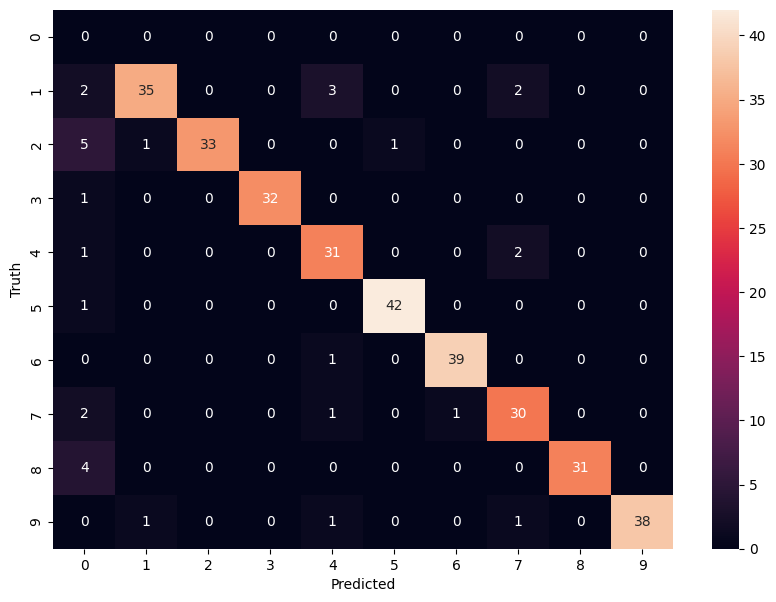

In [15]:
# Generate a confusion matrix to compare the true labels (y_test)
# against the model's predicted labels (y_predicted_labels)
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted_labels)
# Set the size of the figure for the heatmap
plt.figure(figsize=(10, 7))

# Create a heatmap to visualize the confusion matrix
# 'annot=True' annotates each cell with the integer value (formatted as 'd' for decimal)
# 'fmt='d'' specifies numeric formatting for annotations
sns.heatmap(cm, annot=True, fmt='d')

# Label the x-axis as "Predicted"
plt.xlabel("Predicted")

# Label the y-axis as "Truth"
plt.ylabel("Truth")

We want to minimize false positives = symbols labelled correct while they are:

* an error : FP_error

* or a different symbol : FP_symbol

It is fine to have false negative = symbols which are correct but are labelled as:

* an error : FN_error

* or a different symbol: FN_symbol

In [16]:
# Add custom metric false neg false pos
cm_np = np.array(cm)
print(cm_np)
FP_error = np.array([cm_np[0, i] for i in range(1, 9)])
FN_error = np.array([cm_np[i, 0] for i in range(1, 9)])
# /!\ delete uses the index in the np.arange(1,10) not from the cm, which is where the i-1 comes from
FP_symbol = np.array([cm_np[np.delete(np.arange(1, 9), i-1), i].sum() for i in range(1, 9)])
FN_symbol = np.array([cm_np[i, np.delete(np.arange(1, 9), i-1)].sum() for i in range(1, 9)])
print(FN_error)

[[ 0  0  0  0  0  0  0  0  0  0]
 [ 2 35  0  0  3  0  0  2  0  0]
 [ 5  1 33  0  0  1  0  0  0  0]
 [ 1  0  0 32  0  0  0  0  0  0]
 [ 1  0  0  0 31  0  0  2  0  0]
 [ 1  0  0  0  0 42  0  0  0  0]
 [ 0  0  0  0  1  0 39  0  0  0]
 [ 2  0  0  0  1  0  1 30  0  0]
 [ 4  0  0  0  0  0  0  0 31  0]
 [ 0  1  0  0  1  0  0  1  0 38]]
[2 5 1 1 1 0 2 4]


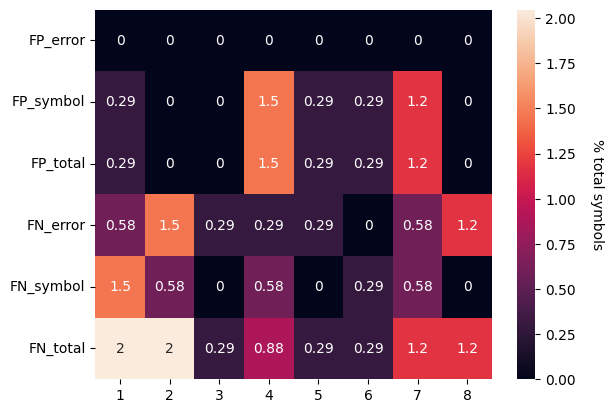

In [17]:
FP_total = FP_error + FP_symbol
FN_total = FN_error + FN_symbol
metrics = np.vstack((FP_error, FP_symbol, FP_total, FN_error, FN_symbol, FN_total))
# Normalize on total number of samples
metrics_n = metrics/cm_np.sum()*100
heatmap = sns.heatmap(metrics_n, annot=True)
cbar = heatmap.collections[0].colorbar
cbar.set_label('% total symbols', rotation=270, labelpad=20)
heatmap.set_xticklabels(range(1, 9))
heatmap.set_yticklabels(["FP_error", "FP_symbol", "FP_total", "FN_error", "FN_symbol", "FN_total"], rotation = 0)
plt.show()

# Save the model

In [18]:
# Save the model to the specified path
model.save("model_CS_new9BC_Epoch90_20240423.keras")

# Evaluate the model on the test dataset to get the loss value & metrics values for the model
test_loss, test_accuracy = model.evaluate(X_test, y_test -1)

# Print out the model's performance on the test dataset
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9426 - loss: 0.2083 
Test Loss: 0.25501370429992676, Test Accuracy: 0.9356725215911865


# TODO

## Implement checkpoint saving of model

## Add curve for loss and accuracy

## Make custom metric
Done, now to implement in model calculation

## Try to classify without the 9
Do not really improve the false positive rate

## Try new scanned sheet for number 9
Worked better, especially with the good brightness/contrast

## Try new test resultsheets